# Spam Detection Baseline

## Project Overview
This notebook contains baseline models for spam detection using SMS data.

In [2]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# 1. Load data
df = pd.read_csv('/content/drive/My Drive/Portfolio/spam.csv', encoding='latin-1')
df = df.rename(columns={'v1': 'class', 'v2': 'sms'})
df = df[['class', 'sms']]

In [4]:
# 2. Basic EDA
## 2.1 Check basic information
# Dataset shape and class distribution
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df['class'].value_counts(normalize=True))

# Dataset information
print("\nDataset Information:")
print(df.info())

# Sample data
print("\nFirst few messages:")
print(df.head())

# Missing values check
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (5572, 2)

Class Distribution:
class
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64
1. Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

3. First few messages:
  class                                                sms
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

4. Missing Values:
class    0
sms      0
dtype: int64


In [6]:
## 2.2 Check most common words
def get_top_words(text_series, n=20):
   words = ' '.join(text_series).lower().split()
   return pd.Series(Counter(words).most_common(n))

# Most common words for each class
print("\nMost common words in Spam messages:")
print(get_top_words(df[df['class']=='spam']['sms']))
print("\nMost common words in Ham messages:")
print(get_top_words(df[df['class']=='ham']['sms']))


Most common words in Spam messages:
0         (to, 682)
1          (a, 373)
2       (call, 342)
3       (your, 263)
4        (you, 252)
5        (the, 204)
6        (for, 201)
7         (or, 188)
8       (free, 180)
9          (2, 169)
10        (is, 152)
11        (ur, 144)
12        (on, 141)
13       (txt, 136)
14      (have, 135)
15      (from, 127)
16       (and, 122)
17         (u, 117)
18      (text, 112)
19    (mobile, 109)
dtype: object

Most common words in Ham messages:
0       (i, 2172)
1     (you, 1665)
2      (to, 1544)
3     (the, 1113)
4       (a, 1046)
5        (u, 874)
6      (and, 845)
7       (in, 786)
8       (my, 741)
9       (is, 710)
10      (me, 584)
11      (of, 518)
12     (for, 496)
13    (that, 442)
14      (it, 440)
15    (have, 433)
16    (your, 413)
17     (but, 413)
18     (are, 405)
19      (so, 399)
dtype: object


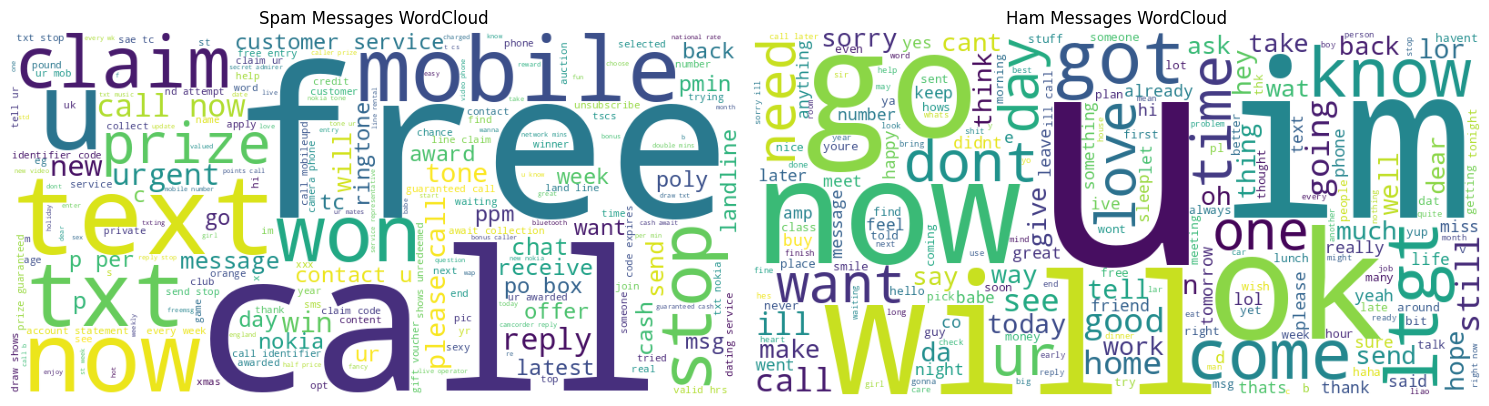

In [13]:
## 2.3 Visualize characteristic words of spam/ham messages using WordCloud
plt.figure(figsize=(15, 5))

# WordCloud for spam messages
plt.subplot(1, 2, 1)
spam_text = ' '.join(df[df['class']=='spam']['processed_text'])
wordcloud_spam = WordCloud(width=800, height=400,
                         background_color='white').generate(spam_text)
plt.imshow(wordcloud_spam)
plt.title('Spam Messages WordCloud')
plt.axis('off')

# WordCloud for ham messages
plt.subplot(1, 2, 2)
ham_text = ' '.join(df[df['class']=='ham']['processed_text'])
wordcloud_ham = WordCloud(width=800, height=400,
                        background_color='white').generate(ham_text)
plt.imshow(wordcloud_ham)
plt.title('Ham Messages WordCloud')
plt.axis('off')

plt.tight_layout()
plt.show()

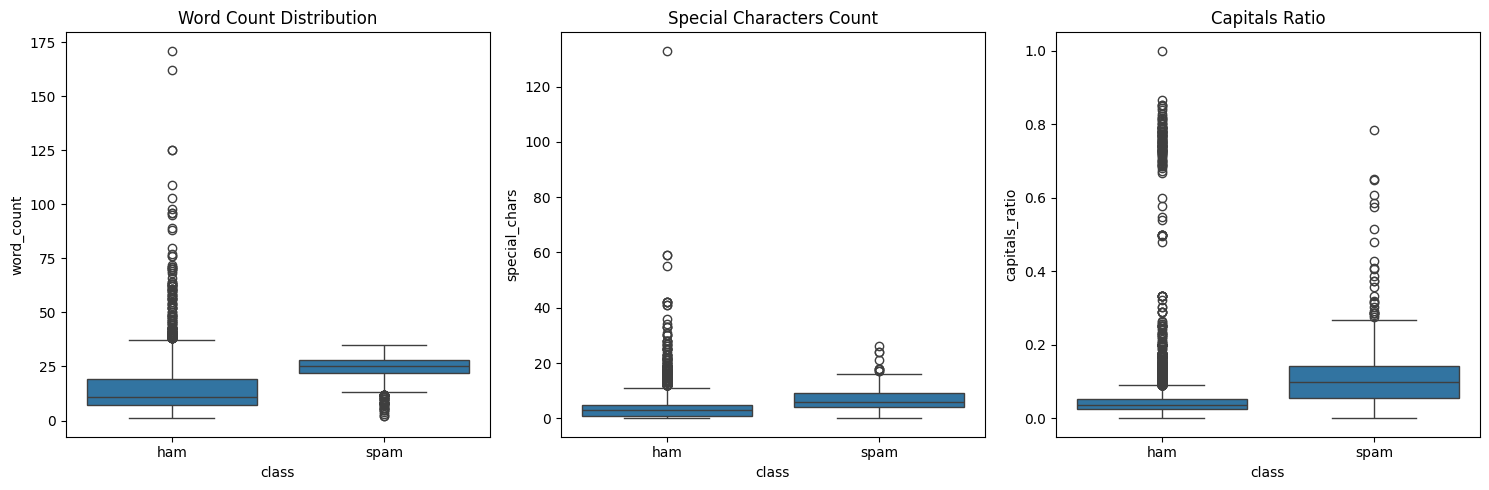


Average metrics by class:
       word_count  special_chars  capitals_ratio
class                                           
ham     14.200622       4.083731        0.059526
spam    23.851406       6.607764        0.110612


In [19]:
## 2.4 Analyze message complexity (sentence length, word count, special character ratio)
def get_text_features(text):
    # Count words
    words = len(text.split())
    # Count special characters
    special_chars = len(re.findall(r'[^a-zA-Z0-9\s]', text))
    # Calculate capitals ratio
    capitals = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0
    return words, special_chars, capitals

# Extract features
df[['word_count', 'special_chars', 'capitals_ratio']] = pd.DataFrame(
    df['sms'].apply(get_text_features).tolist()
)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Word count distribution
sns.boxplot(x='class', y='word_count', data=df, ax=axes[0])
axes[0].set_title('Word Count Distribution')

# Special characters distribution
sns.boxplot(x='class', y='special_chars', data=df, ax=axes[1])
axes[1].set_title('Special Characters Count')

# Capitals ratio distribution
sns.boxplot(x='class', y='capitals_ratio', data=df, ax=axes[2])
axes[2].set_title('Capitals Ratio')

plt.tight_layout()
plt.show()

# Print average metrics
print("\nAverage metrics by class:")
print(df.groupby('class')[['word_count', 'special_chars', 'capitals_ratio']].mean())

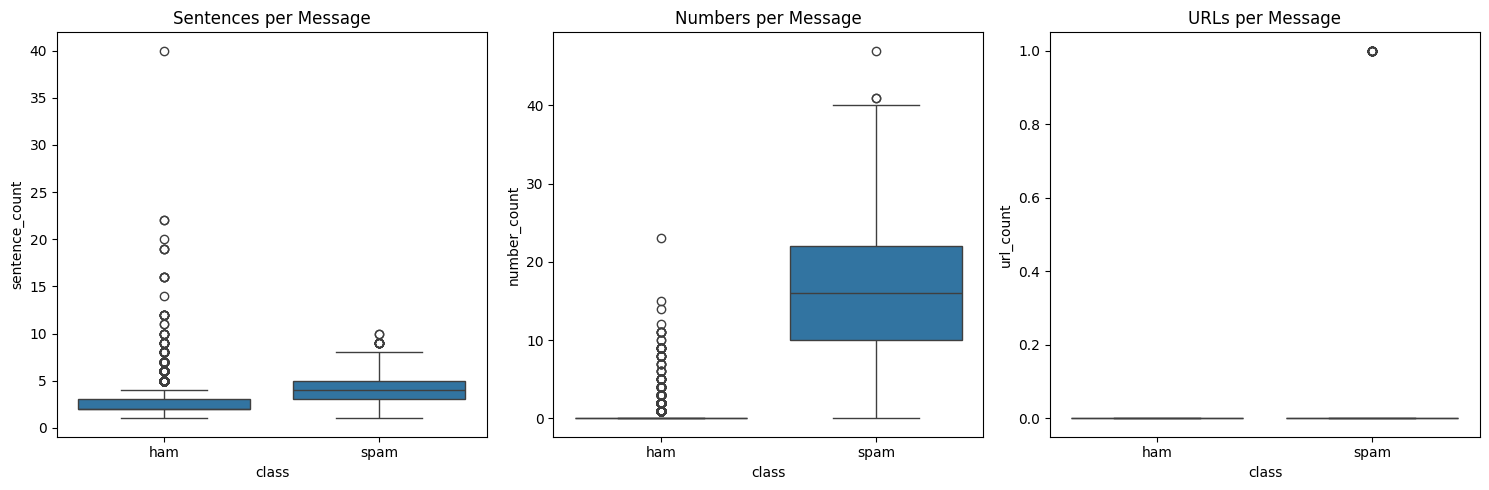

In [18]:
## 2.5 Analyze sentence structure and content patterns
def get_sentence_features(text):
    # Count sentences based on punctuation marks
    sentences = len(re.findall(r'[.!?]+', text)) + 1
    # Count numeric values
    numbers = len(re.findall(r'\d', text))
    # Count URLs in text
    urls = len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))
    return sentences, numbers, urls

# Extract structural features
df[['sentence_count', 'number_count', 'url_count']] = pd.DataFrame(
    df['sms'].apply(get_sentence_features).tolist()
)

# Visualization of structural patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sentence count distribution
sns.boxplot(x='class', y='sentence_count', data=df, ax=axes[0])
axes[0].set_title('Sentences per Message')

# Numeric count distribution
sns.boxplot(x='class', y='number_count', data=df, ax=axes[1])
axes[1].set_title('Numbers per Message')

# URL count distribution
sns.boxplot(x='class', y='url_count', data=df, ax=axes[2])
axes[2].set_title('URLs per Message')

plt.tight_layout()
plt.show()

In [7]:
# 3. Simple preprocessing function
def preprocess_text(text):
   text = text.lower()
   text = re.sub(r'[^a-zA-Z\s]', '', text)
   text = re.sub(r'\s+', ' ', text).strip()
   return text

df['processed_text'] = df['sms'].apply(preprocess_text)

In [8]:
# 4. Modeling
# Split data
X_train, X_test, y_train, y_test = train_test_split(
   df['processed_text'],
   df['class'],
   test_size=0.2,
   random_state=42
)

In [9]:
# 4.1 Baseline 1: CountVectorizer + Logistic Regression
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_vec, y_train)

# Evaluate performance
lr_pred = lr_model.predict(X_test_vec)
print("\nLogistic Regression Results:")
print(classification_report(y_test, lr_pred))


Logistic Regression Results:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [10]:
# alternative way to check the model performance
print("\nKey Metrics Summary:")
print(f"Overall Accuracy: {accuracy_score(y_test, lr_pred):.3f}")
print("\nPer-Class Metrics:")
print(f"Ham - F1 Score: {f1_score(y_test, lr_pred, pos_label='ham'):.3f}")
print(f"Spam - F1 Score: {f1_score(y_test, lr_pred, pos_label='spam'):.3f}")


Key Metrics Summary:
Overall Accuracy: 0.978

Per-Class Metrics:
Ham - F1 Score: 0.988
Spam - F1 Score: 0.914


In [11]:
# 4.2 Baseline 2: TF-IDF + Random Forest
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate performance
rf_pred = rf_model.predict(X_test_tfidf)
print("\nRandom Forest Results:")
print(classification_report(y_test, rf_pred))


Random Forest Results:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       1.00      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [12]:
# alternative way to check the model performance
print("\nKey Metrics Summary:")
print(f"Overall Accuracy: {accuracy_score(y_test, rf_pred):.3f}")
print("\nPer-Class Metrics:")
print(f"Ham - F1 Score: {f1_score(y_test, rf_pred, pos_label='ham'):.3f}")
print(f"Spam - F1 Score: {f1_score(y_test, rf_pred, pos_label='spam'):.3f}")


Key Metrics Summary:
Overall Accuracy: 0.972

Per-Class Metrics:
Ham - F1 Score: 0.984
Spam - F1 Score: 0.885
